In [1]:
import pickle
import torch
from encoder import Encoder
from Decoder import LSTMAttnDecoder
import os
import json
from torchvision import transforms
from torchvision.transforms import Resize, ToTensor, Lambda, Grayscale

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [2]:
with open("Tokenizer/token_to_char.pkl", "rb") as f:
    token_to_char = pickle.load(f)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
encoder = Encoder().from_pretrained("yamanoko/SeqCLR_Encoder_fine_tuned")
decoder = LSTMAttnDecoder(256, len(token_to_char)).from_pretrained("yamanoko/SeqCLR_Decoder_fine_tuned")
encoder = encoder.to(device)
decoder = decoder.to(device)

In [3]:
with open("Tokenizer/char_to_token.pkl", 'rb') as f:
    char_to_token = pickle.load(f)

SOS_token = char_to_token['<SOS>']

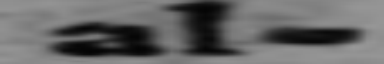

['a', 'l', 'e', '<EOS>']


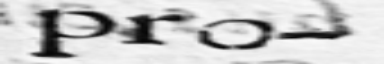

['p', 'r', 'o', 'a', '<EOS>']


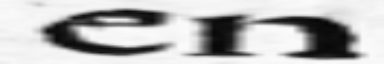

['e', 'm', '<EOS>']


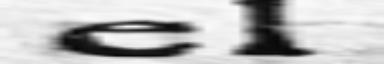

['e', 'l', '<EOS>']


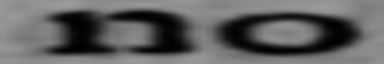

['n', 'o', '<EOS>']


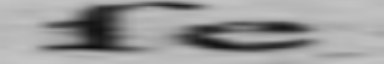

['s', 'e', '<EOS>']


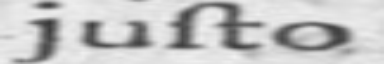

['j', 'u', 's', 't', 'o', '<EOS>']


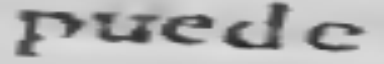

['p', 'u', 'e', 'd', 'e', '<EOS>']


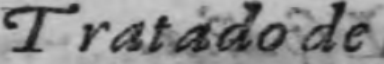

['t', 'r', 'a', 's', 'a', 'l', 'o', '<EOS>']


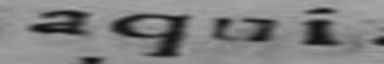

['a', 'q', 'u', 'i', '<EOS>']


In [4]:
from PIL import Image
from torchvision.transforms import ToPILImage
import random

test_dataset_folder = "test_images"

img_size = (64, 384)

data_transform = transforms.Compose([
            Lambda(lambda img: img.convert("RGB")),
            Grayscale(num_output_channels=3),
            Resize(img_size),
            ToTensor(),  # Convert image to PyTorch Tensor in CHW format
        ])

decoder.eval()

test_data_files = os.listdir(test_dataset_folder)
random.shuffle(test_data_files)

with torch.no_grad():
    for filename in test_data_files[:10]:
        image = Image.open(os.path.join(test_dataset_folder, filename))
        image = data_transform(image)
        display(ToPILImage()(image))
        image_tensor = image.unsqueeze(0).to(device)
        encoder_outputs, decoder_hidden = encoder(image_tensor)
        decoder_input = torch.tensor([[SOS_token]] * image_tensor.size(0)).to(device)
        prediction = []
        for t in range(20):  # Assuming maximum sequence length is 50
            decoder_output, decoder_hidden = decoder(decoder_input, decoder_hidden, encoder_outputs)
            _, topi = decoder_output.topk(1)
            decoder_input = topi.detach()
            prediction.append(decoder_input.item())
            if decoder_input.item() == char_to_token['<EOS>']:
                break
        print([token_to_char[i] for i in prediction])